In [28]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [29]:
import h5py

In [30]:
import tensorflow as tf

In [31]:
from uatu.watchers import *

In [32]:
from scipy.ndimage import rotate

In [33]:
def compute_attacked_map(model_init_fn, cost_fn, network_fname,\
                         x_np, target_y_np, n_steps = 10, training=False):
    tf.reset_default_graph()
    x = tf.placeholder(tf.float32, [None, 256, 256,1])
    #y = tf.placeholder(tf.float32, [None,2])
    y = tf.placeholder(tf.float32, [None,2])
    
    #training = tf.placeholder(tf.bool, name='training')
    preds = model_init_fn(x, training=training)
    
    #print [n.name for n in tf.get_default_graph().as_graph_def().node]

    
    loss = cost_fn(y, preds)
    grads = tf.gradients(loss, x)

    # learning rate maybe needed?
    dX = tf.divide(grads, tf.norm(grads))[0]

    with tf.device('/cpu:0'):
        saver = tf.train.Saver()

    with tf.Session() as sess:
        saver.restore(sess, network_fname)
        key_dict = {}

        x_attacked_np = x_np.copy()
        x_orig_power = x_attacked_np.mean()
        step = 1e-3
        for i in xrange(n_steps):
            feed_dict = {x: x_attacked_np,y:target_y_np}#, training: False}
            dX_np, loss_np = sess.run([dX, loss], feed_dict=feed_dict)#[0][0]

            #x_attacked_np-=step*dX_np#
            #print dX_np.shape
            x_attacked_np-=step*rotate(dX_np.squeeze(), 0).reshape((1, 256, 256, 1))
            
        # ensure the attacked map has the same normalization as the old one.
    x_attacked_np = (x_attacked_np/x_attacked_np.mean())*x_orig_power

    return x_attacked_np

In [34]:
def test(model_init_fn, x_np, fname,  n_samples = 10, training=False):
    tf.reset_default_graph()

    x = tf.placeholder(tf.float32, [None, 256,256,1], name = 'x')

    preds = model_init_fn(x, training=training)

    with tf.device('/cpu:0'):
        saver = tf.train.Saver()


    with tf.Session() as sess:
        with tf.device('/cpu:0'):
            saver.restore(sess, fname)

        #assert y_np.shape[0] == 1 , 'batchsize greater than 1'
        samples = []
        feed_dict = {x: x_np}#, training: False}

        for j in xrange(n_samples):
            preds_np  = sess.run(preds, feed_dict=feed_dict)
            samples.append(preds_np)

    return np.vstack(samples)

In [35]:
f = h5py.File('../data/UatuLightconeTraining.hdf5', 'r')
mean, std =  f.attrs['mean'], f.attrs['std']
f.close()

In [36]:
f = h5py.File('../data/UatuLightconeSameSeed.hdf5', 'r')
#for boxno in xrange(5):
boxno = 2#3
target_boxno = 3
test_X = np.array(f['Box%03d'%boxno]["X"][()])
test_Y = f['Box%03d'%boxno]['Y'][0].reshape((1,2))

target_X = np.array(f['Box%03d'%target_boxno]["X"][()])
target_Y = f['Box%03d'%target_boxno]['Y'][0].reshape((1,2))
f.close()

In [37]:
target_X.shape

(289, 256, 256, 1)

In [ ]:
test_X = (test_X-mean)/(std)
target_X = (target_X-mean)/(std)

In [38]:
n = 200
batch_size = 1 

X = test_X[n, :, :, :].reshape((1, test_X.shape[1],\
                                test_X.shape[2], test_X.shape[3]))
#X = (X-mean)/(std)
X = np.tile(X, (batch_size, 1, 1, 1) )
Y = test_Y[0, :].reshape((1, test_Y.shape[1]))
Y = np.tile(Y, (batch_size, 1))

In [39]:
targ_X = target_X[n, :, :, :].reshape((1, test_X.shape[1],\
                                test_X.shape[2], test_X.shape[3]))
#targ_X = (targ_X-mean)/(std)

In [40]:
net = 'bayes'
network_fname = '../networks/gupta_bayes_net_kappa-45000'
model_init_fn = gupta_bayesian_network_init_fn
cost_fn = original_bayes_cost_fn
training=True

In [41]:
X_attacked = compute_attacked_map(model_init_fn, cost_fn, network_fname,\
                            X, target_Y, n_steps = 300, training=training)

INFO:tensorflow:Restoring parameters from ../networks/gupta_bayes_net_kappa-45000


In [42]:
true_samples = test(model_init_fn, X, network_fname,  100, training)
attacked_samples = test(model_init_fn, X_attacked, network_fname,  100, training)

INFO:tensorflow:Restoring parameters from ../networks/gupta_bayes_net_kappa-45000
INFO:tensorflow:Restoring parameters from ../networks/gupta_bayes_net_kappa-45000


In [43]:
true_samples[:,0].mean(),attacked_samples[:,0].mean()

(0.2848355, 0.33759204)

(0.2, 0.4)

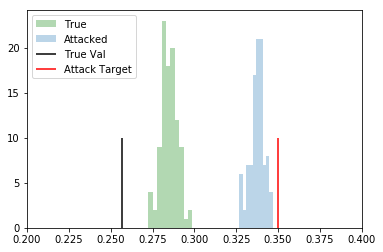

In [44]:
plt.hist(true_samples[:, 0], density=False, color = 'g', alpha = 0.3, label = "True");
plt.hist(attacked_samples[:, 0], density=False, alpha = 0.3, label = 'Attacked');
plt.vlines(Y[0, 0], 0, 10, label = 'True Val');
plt.vlines(target_Y[0,0], 0, 10, color = 'r', label = 'Attack Target');
plt.legend(loc='best')
plt.xlim([0.2, 0.4])

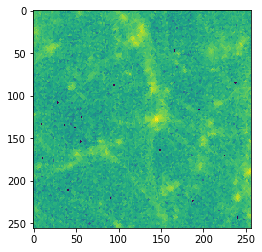

In [45]:
plt.imshow(X[0,:,:,0])

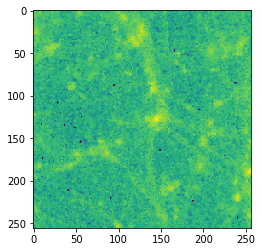

In [46]:
plt.imshow(X_attacked[0,:,:,0])

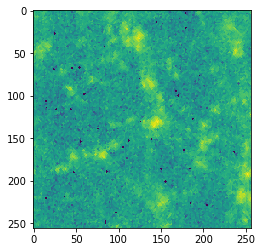

In [47]:
plt.imshow(targ_X[0,:,:,0])

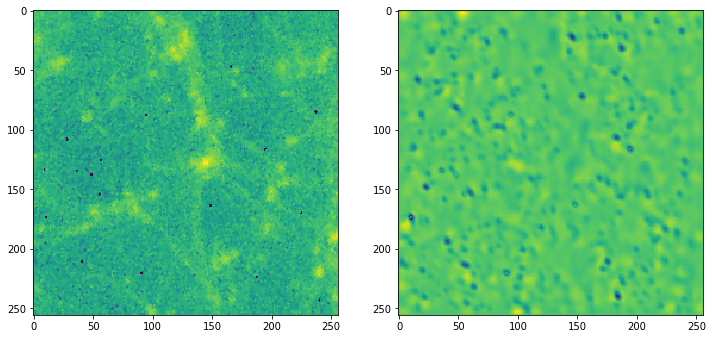

In [48]:
diff = X[0,:,:,0] - X_attacked[0,:,:,0]
fig = plt.figure(figsize = (12, 6))
plt.subplot(121)
plt.imshow(X.squeeze())
plt.subplot(122)
plt.imshow(-diff)

In [49]:
from scipy.fftpack import fft2

In [50]:
def azimuthalAverage(image, center=None):
    """
    Calculate the azimuthally averaged radial profile.

    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is 
             None, which then uses the center of the image (including 
             fracitonal pixels).
    
    """
    # Calculate the indices from the image
    y, x = np.indices(image.shape)

    if not center:
        center = np.array([(x.max()-x.min())/2.0, (x.max()-x.min())/2.0])

    r = np.hypot(x - center[0], y - center[1])

    # Get sorted radii
    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind]
    i_sorted = image.flat[ind]

    # Get the integer part of the radii (bin size = 1)
    r_int = r_sorted.astype(int)

    # Find all pixels that fall within each radial bin.
    deltar = r_int[1:] - r_int[:-1]  # Assumes all radii represented
    rind = np.where(deltar)[0]       # location of changed radius
    nr = rind[1:] - rind[:-1]        # number of radius bin
    
    # Cumulative sum to figure out sums for each radius bin
    csim = np.cumsum(i_sorted, dtype=float)
    tbin = csim[rind[1:]] - csim[rind[:-1]]

    radial_prof = tbin / nr

    return radial_prof

In [51]:
from scipy import fftpack
import numpy as np
import pylab as py
#import radialProfile

def image_ps(image):
  
    # Take the fourier transform of the image.
    F1 = fftpack.fft2(image)

    # Now shift the quadrants around so that low spatial frequencies are in
    # the center of the 2D fourier transformed image.
    F2 = fftpack.fftshift( F1 )

    # Calculate a 2D power spectrum
    psd2D = np.abs( F2 )**2

    # Calculate the azimuthally averaged 1D power spectrum
    psd1D = azimuthalAverage(psd2D)

    return psd1D

In [53]:
X.shape

(289, 256, 256, 1)

In [56]:
attacked_ps = np.zeros((X.shape[0], 179))
normal_ps = np.zeros((X.shape[0], 179))
target_ps = np.zeros((X.shape[0], 179))
diff_ps = np.zeros((X.shape[0], 179))
diff2_ps = np.zeros((X.shape[0], 179))

for n in range(X.shape[0]):
    print n
    X_attacked = compute_attacked_map(model_init_fn, cost_fn, network_fname,\
                            X[n].reshape(1, X.shape[1], X.shape[2], X.shape[3])\
                        , target_Y, n_steps = 300, training=training)
    attacked_ps[n] = image_ps(X_attacked.squeeze())
    target_ps[n] = image_ps(target_X[n].squeeze())

    normal_ps[n] = image_ps(X[n].squeeze())
    diff_ps[n] = image_ps( (X_attacked - X[n]).squeeze())
    diff2_ps[n] = image_ps( (X_attacked - target_X[n]).squeeze())

0
INFO:tensorflow:Restoring parameters from ../networks/gupta_bayes_net_kappa-45000
1
INFO:tensorflow:Restoring parameters from ../networks/gupta_bayes_net_kappa-45000
2
INFO:tensorflow:Restoring parameters from ../networks/gupta_bayes_net_kappa-45000
3
INFO:tensorflow:Restoring parameters from ../networks/gupta_bayes_net_kappa-45000
4
INFO:tensorflow:Restoring parameters from ../networks/gupta_bayes_net_kappa-45000
5
INFO:tensorflow:Restoring parameters from ../networks/gupta_bayes_net_kappa-45000
6
INFO:tensorflow:Restoring parameters from ../networks/gupta_bayes_net_kappa-45000
7
INFO:tensorflow:Restoring parameters from ../networks/gupta_bayes_net_kappa-45000
8
INFO:tensorflow:Restoring parameters from ../networks/gupta_bayes_net_kappa-45000
9
INFO:tensorflow:Restoring parameters from ../networks/gupta_bayes_net_kappa-45000
10
INFO:tensorflow:Restoring parameters from ../networks/gupta_bayes_net_kappa-45000
11
INFO:tensorflow:Restoring parameters from ../networks/gupta_bayes_net_ka

97
INFO:tensorflow:Restoring parameters from ../networks/gupta_bayes_net_kappa-45000
98
INFO:tensorflow:Restoring parameters from ../networks/gupta_bayes_net_kappa-45000
99
INFO:tensorflow:Restoring parameters from ../networks/gupta_bayes_net_kappa-45000
100
INFO:tensorflow:Restoring parameters from ../networks/gupta_bayes_net_kappa-45000
101
INFO:tensorflow:Restoring parameters from ../networks/gupta_bayes_net_kappa-45000
102
INFO:tensorflow:Restoring parameters from ../networks/gupta_bayes_net_kappa-45000
103
INFO:tensorflow:Restoring parameters from ../networks/gupta_bayes_net_kappa-45000
104
INFO:tensorflow:Restoring parameters from ../networks/gupta_bayes_net_kappa-45000
105
INFO:tensorflow:Restoring parameters from ../networks/gupta_bayes_net_kappa-45000
106
INFO:tensorflow:Restoring parameters from ../networks/gupta_bayes_net_kappa-45000
107
INFO:tensorflow:Restoring parameters from ../networks/gupta_bayes_net_kappa-45000
108
INFO:tensorflow:Restoring parameters from ../networks

193
INFO:tensorflow:Restoring parameters from ../networks/gupta_bayes_net_kappa-45000
194
INFO:tensorflow:Restoring parameters from ../networks/gupta_bayes_net_kappa-45000
195
INFO:tensorflow:Restoring parameters from ../networks/gupta_bayes_net_kappa-45000
196
INFO:tensorflow:Restoring parameters from ../networks/gupta_bayes_net_kappa-45000
197
INFO:tensorflow:Restoring parameters from ../networks/gupta_bayes_net_kappa-45000
198
INFO:tensorflow:Restoring parameters from ../networks/gupta_bayes_net_kappa-45000
199
INFO:tensorflow:Restoring parameters from ../networks/gupta_bayes_net_kappa-45000
200
INFO:tensorflow:Restoring parameters from ../networks/gupta_bayes_net_kappa-45000
201
INFO:tensorflow:Restoring parameters from ../networks/gupta_bayes_net_kappa-45000
202
INFO:tensorflow:Restoring parameters from ../networks/gupta_bayes_net_kappa-45000
203
INFO:tensorflow:Restoring parameters from ../networks/gupta_bayes_net_kappa-45000
204
INFO:tensorflow:Restoring parameters from ../netwo

[]

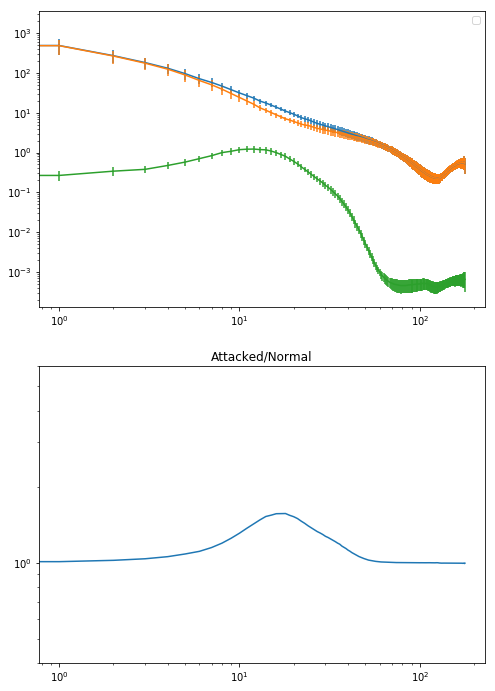

In [57]:
fig = plt.figure(figsize = (8, 12))
plt.subplot(211)
plt.errorbar(range(179), attacked_ps.mean(axis = 0), yerr=attacked_ps.std(axis=0) )
plt.errorbar(range(179), normal_ps.mean(axis = 0), yerr = normal_ps.std(axis=0))
plt.errorbar(range(179), diff_ps.mean(axis = 0), yerr = diff_ps.std(axis=0))
plt.legend(loc='best')
plt.loglog();
plt.subplot(212)
plt.title("Attacked/Normal")
plt.plot(attacked_ps.mean(axis=0)/normal_ps.mean(axis=0))
plt.ylim([0.4, 6])
plt.loglog()

[]

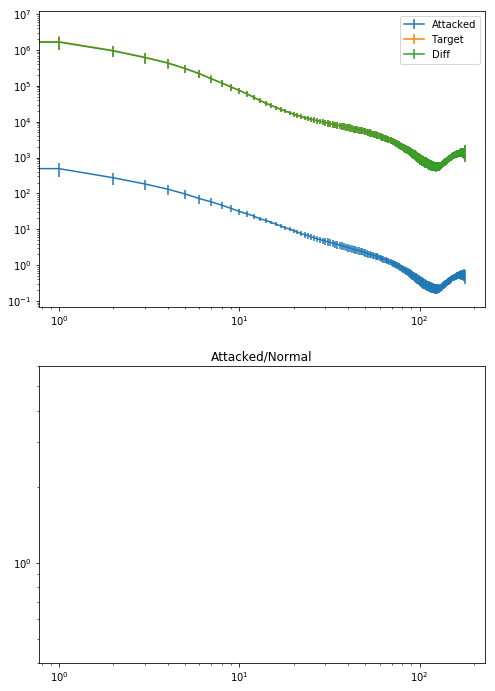

In [68]:
fig = plt.figure(figsize = (8, 12))
plt.subplot(211)
plt.errorbar(range(179), attacked_ps.mean(axis = 0), yerr=attacked_ps.std(axis=0), label = 'Attacked' )
plt.errorbar(range(179), target_ps.mean(axis = 0), yerr = target_ps.std(axis=0), label = 'Target')
plt.errorbar(range(179), diff2_ps.mean(axis = 0), yerr = diff2_ps.std(axis=0), label = 'Diff')
plt.legend(loc='best')
plt.loglog();
plt.subplot(212)
plt.title("Attacked/Normal")
plt.plot(attacked_ps.mean(axis=0)/target_ps.mean(axis=0))
plt.ylim([0.4, 6])
plt.loglog()

In [ ]:
np.savetxt('attacked_ps_boxno_%d_ty_%s_net_%s.npy'%(boxno, ty, net), attacked_ps)
np.savetxt('normal_ps_boxno_%d_ty_%s_net_%s.npy'%(boxno, ty, net), normal_ps)
np.savetxt('diff_ps_boxno_%d_ty_%s_net_%s.npy'%(boxno, ty, net), diff_ps)

In [ ]:
%%bash
ls attacked*.npy -ltr